# Deep Learning

Deep Learning is a subfield of machine learning concerned with algorithms inspired by the structure and function of the brain called artificial neural networks.. Using the data as input, we can train a deep neural network to either predict the classes of that data, or the parameter values of that data. We will do this using various modules from the `keras` python deep learning API package. Similar to what we have seen in both the unsupervised and the supervised case, you can think of a deep neural network as essentially a function approximater, such as

$$ y = f (x) $$

where $y$ is the output and $x$ is the data. In the deep learning case, both the data $x$ and the labels $y$ are known. The complexity of the function that we use to map our input $x$ to our output $y$ is entirely up to you, the user. We will discuss below various different types of deep learning algorithms that are available to you and all the various knobs (hyperparameters) you can tune to solve your problem. Have fun!

In [3]:
%matplotlib notebook
%config InlineBackend.figure_format = "retina"

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file

import numpy as np
import random
import sys
import io

## Exercise 1: Text Generation using Long Short Term Memory (LSTM) Networks

Glancing at the figure below we can see the overall process of a Long Short Term Memory (LSTM) network. 

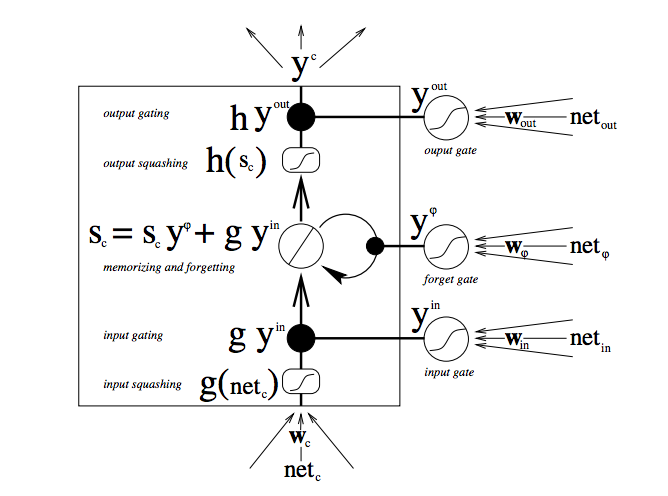
<center>Source: <a href="https://skymind.ai/wiki/lstm">link</a></center>

Looking at the bottom of the figure, we can see that data flows into the cell from multiple locations.


The data is to be used for the first exercise is saved to this repository in the `nietzsche.txt`. The dataset is a freely avaiable text dataset of [Nietzsche's writings](https://s3.amazonaws.com/text-datasets/nietzsche.txt) you can download. We will use the keras data utility `get_file` to download the text. This dataset will need spliting up into smaller sequences that can then be used to train the LSTM.  Load in this data and inspect it.

* What is the shape of the data?
* What does this tell you about the number of features that describes the data?
* How many different types of data is there?

In [4]:
# get the data
path = get_file('nietzsche.txt', origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
with io.open(path, encoding='utf-8') as f:
    text = f.read().lower()
print('corpus length:', len(text))



corpus length: 600893


Now that you have loaded in the dataset, we should figure out the total number of characters in the dataset. You can do this by turning the `text` variable into a python set and that set into list using both python built-in function `list` and `set`. You can order the text using the built-in python function `sorted`.

In [5]:
# how many different characters is that?
chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 57


Now we will split the dataset up into a list of sub-sequences, which is what the LSTM requires as input. Each one of these subsequences will have a max length of 40 characters. In addition, make a seperate list containing the next character that follows each subsequence. Make sure to leave at least 40 characters at the end of the dataset to be set aside as testing data to be used later.

In [6]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 200285


Put the sequences into an array called $x$ and the list of next characters into an array called $y$. 

In [7]:
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Vectorization...


Now that we have our training data/labels loaded in, we can finally construct our LSTM neural network. To do this, use the Keras sequential LSTM module which we have imported in the first cell block. If you're having trouble constructing the model, please refer to the following LSTM example post or ask a demonstrater for some hints. [LSTM example](https://medium.com/@dclengacher/keras-lstm-recurrent-neural-networks-c1f5febde03d) 

In [8]:
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

Next, compile your model using a keras [optimizer](https://keras.io/optimizers/) of your choice.

In [9]:
# compile the model
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Fit your model. This will take about 3-5 minutes per epoch on a CPU. If you have a built-in GPU, feel free to try using that as well.

In [10]:
model.fit(x, y,
          batch_size=128,
          epochs=10)

Epoch 1/10
  2048/200285 [..............................] - ETA: 5:08 - loss: 3.3329

KeyboardInterrupt: 

If you'd rather not wait until the network is done training for 10 epochs you can suspend the cell above by pressing the stop button next to the run button. Then add the following helper functions to sample from the model after every 1 epoch. In order to use this, you can set the `print_callback` variable as a callback in your `model.fit` function. 

`model.fit(x,y,batch_size=128,epochs=10,callback=your_callback_variable)`

In [11]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
        
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
        
model.fit(x, y,
          batch_size=128,
          epochs=10,
callbacks=[print_callback])


Epoch 1/10
200285/200285 [==============================] - 126s 629us/step - loss: 1.9740

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "c mode,
consisted precisely in resistanc"
c mode,
consisted precisely in resistance in the real that it is the made in the hand that it is the constiture that is they be the care that it is not it is a man a man of the contical the herd that it is a man it is that it is a such the really and the sense of the came the comperent that it is the compertial that it is the compares that it is the came that it is not it is a man the comperent to the still in the religious to the relig
----- diversity: 0.5
----- Generating with seed: "c mode,
consisted precisely in resistanc"
c mode,
consisted precisely in resistance: with a certain litter and the entince, a the is the readay with their the power it a tith a man entince with a
thill sach it is a may the find hand they it not is their craint of the constition, in one i

KeyboardInterrupt: 

Feel free to play around with hyperparameters such as batch size, number of epochs, optimizer, number of LSTM layers, etc. If you're feeling especially ambitious, you can also try loading in and training over other datasets from the following [Project Gutenberg](https://www.gutenberg.org/ebooks/search/%3Fsort_order%3Ddownloads). Project Gutenberg has a large number of .txt free books which are no longer protected by copyright. An example of a link I might download a book from can be found at the following [link](http://www.gutenberg.org/cache/epub/11/pg11.txt).

## Classification of the MNIST Digits Dataset using Convolutional Neural Networks

Convolutional neural networks (CNNs) are typically composed of layers of 2-D nuerons known as filters. Similar to a fully-connected deep neural network, each one of these filters is also fully-connected all the filters in both the next and previous convolutional layer. 

In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD
from keras import backend as K

import matplotlib.pyplot as plt

Using TensorFlow backend.


For this exercise we will be using MNIST, which is a handwrriten digit database with a training set of 60,000 handwritten 2D digital images and a test set of 10,000 handwritten 2D digital images. The images are all 28x28 pixels and greyscale. It is available [here](http://yann.lecun.com/exdb/mnist/), but is included in Keras and will automatically download.

First, load in the MNIST data using the `mnist.load_data` keras module [mnist load data ex](https://keras.io/datasets/).

In [2]:
# load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Here, you should end up with two sets of arrays (possibly with $x$ in the name) which are the training/testing images and two sets of arrays (possibly with $y$ in the variable name) which are the labels.

Try plotting a 9 of the images (using $x$ training set or $x$ testing set) with the `matplotlib` [subplot](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) and [imshow](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html) modules.

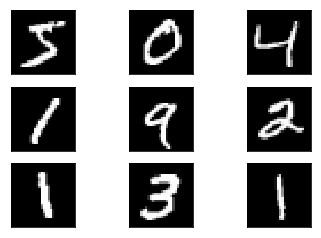

In [3]:
fig, axs = plt.subplots(3,3)
axs = axs.ravel()
for i in range(len(axs)):
    axs[i].imshow(x_train[i].reshape(28,28), cmap='gray')
    axs[i].set_xticks([])
    axs[i].set_yticks([])

We'll define some general hyperparameters which we will be using during training below. You can change the values of these hyperparameters later on.

In [4]:
batch_size = 128    # number of images passed each iteration
num_classes = 10    # digits 0 to 9
epochs = 20         # number of full passes of the dataset

For the CNN, the data needs to be parsed as a 2D array, rather than a 1D array. Reshape your training images to be number_samples x number_pixels x number_pixels x 1. Do this for both the training and test sets. Additionally, it is generally good practice to normalize your training/testing set, which in 

In [5]:
# input image dimensions
img_rows, img_cols = 28, 28

# reshape data
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000,)
60000 train samples
10000 test samples


Use the keras module `keras.utils.to_categorical` to convert your training/testing labels from integer to binary class matrices (e.g. from (0) to (1,0,0),from (1) to (0,1,0), and from (2) to (0,0,1)).

In [6]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

We've now finally gotten to stage where we can define the structure of our deep convolutional neural network module. Refer to the `Building the module` section of the following link for an example about how you might go about doing this. [link](https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5)

In [7]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# input to dense layer needs to be 1D array
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

There are several different hyperparameters that you can play with. I would try adjusting the following after having gone through one training session of your network (we will do this in the cells below):
-  Dropout
-  Number of hidden layers
-  Max pooling
-  Number of filters/neurons per layer
-  Activation functions in each layer

Compile the CNN model using the keras `model.compile` function. See the `compiling the model` section in the following link for an example on how to apply this: [link](https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5)

In [8]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr = 0.01, momentum = 0.9, nesterov = True),
metrics=['accuracy'])

Train your model on the training data/labels using the keras `model.fit` function. Once your model has been trained, you can test the accuracy of your model using the keras `model.evaluate` function. The fitting function will return the loss of the neural network after training and the evaluate function will return an accuracy percentage score of the neural network. Ideally, you should be aiming for 95+ percent accuracy. 

See the `training the model` section in the following link for an example on how to apply the `model.fit` function: [link](https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5)

In [9]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 31s 519us/step - loss: 0.4885 - acc: 0.8471 - val_loss: 0.1418 - val_acc: 0.9559
Epoch 2/20
60000/60000 [==============================] - 29s 478us/step - loss: 0.1918 - acc: 0.9429 - val_loss: 0.0756 - val_acc: 0.9768
Epoch 3/20
  512/60000 [..............................] - ETA: 28s - loss: 0.1314 - acc: 0.9648

KeyboardInterrupt: 

## Exercise 3: Estimating the Frequency of a Sine Wave

In this exercise, we will be using a simple dense deep neural network much like the one seen in the figure below.

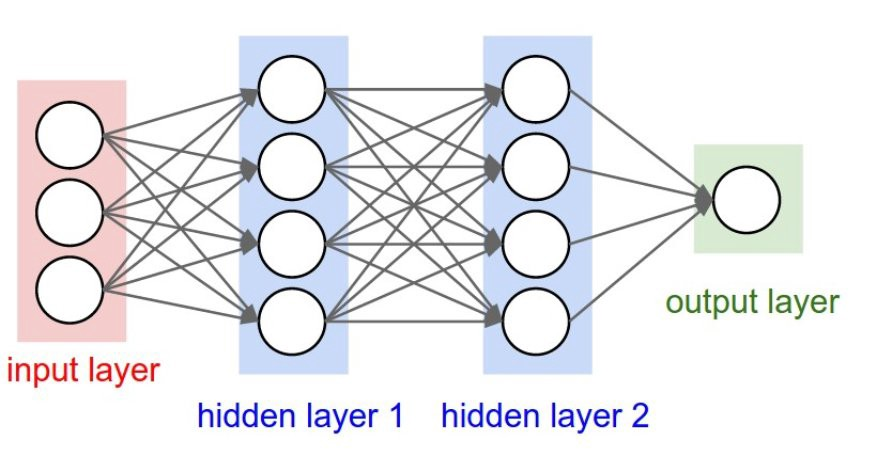


A single layer in this network can be described by

$y_i = \sigma(w_1 \times x_1 + ... + w_m \times x_m )$,

where $x_m$ is the mth input, $y_m$ is the mth output and $w$ is the corresponding weight for the mth neuron. In this exercise, our input, $x$, will be a set of 1-D sine-wave signals. What we will be trying to predict given those signals will be some parameters, $y$,  that describe the sine-wave signals. 

In [2]:
# import required modules
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, Flatten
from keras.optimizers import SGD
from matplotlib import pyplot as plt

First, we will define some hyperparameters (knobs you can turn) which will affect the accuracy and behavior of the network during training. You can leave them as is for now, but may come back to this cell later to change them as you wish.

In [3]:
# define some global parameters
max_freq = 10. # maximum allowed frequency of the sine-wave
Nsamples = 200 # sampling frequency above niquist
Nsignals = 10000 # total number of signals to generate

# network params
epochs = 20 # total number of training epochs
batch_size = 64 # number of signals to send into neural network per training iteration

I have provided below a general function which takes as input frequency and phase that we will be using to generate sine-wave signals. However, if you're feeling particularly keen, you may also try other functions such as sine-Gaussian waveforms.

In [4]:
def gen_sine(frequency, phase):
    "Generate a sinusoidal signal with a given frequeny and phase shift"
    return np.sin(frequency * np.linspace(phase, phase + 2. * np.pi, Nsamples))

### Make Data

Below, I have provided code that will generate both the sine-wave signals $X$ and the parameters of those signals $y$ in a format that will be easy for the deep neural network read in.


In [6]:
# generate parameter labels
Y = np.array([np.random.uniform(0.1,max_freq,Nsignals),np.random.uniform(0,1,Nsignals)]).T

# iterate through parameters and generate sine waves
X = np.array([gen_sine(y[0], y[1]) for y in Y])


# split data into train/test sets

# get a random set of indices
train_idx = np.random.randint(X.shape[0], size=int(0.9*X.shape[0]))
test_idx = np.random.randint(X.shape[0], size=int(0.1*X.shape[0]))

# split the data
x_train, x_test = X[train_idx,:], X[test_idx,:]
y_train, y_test = Y[train_idx,:], Y[test_idx,:]

Now that you have both your input data $X$ and your parameter labels for that input data $Y$, make a few plots of the sine-waves contained in $X$. Is there enough variation from signal to signal? Is the frequency too high? Is the length of the time series long enough? 

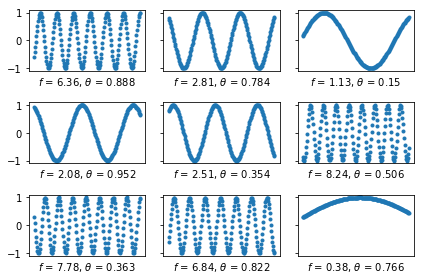

In [8]:
fig, axs = plt.subplots(3,3, sharex = True, sharey = True)
axs = axs.ravel()
for i in range(len(axs)):
    axs[i].plot(X[i], '.')
    axs[i].set_xticks([])
    axs[i].set_xlabel(r'$f$ = {0:.3}, $\theta$ = {1:.3}'.format(Y[i,0], Y[i,1]))
plt.tight_layout()


If you're satisfied with the quality of the input that you will be using, we can set up our deep dense neural network model. To do this, please refer to the following [link](https://keras.io/getting-started/sequential-model-guide/) for information on how to set this up. 

Some tips:
-  Use the sequential model.
-  Start out with 1-2 hidden layers (i.e. `Dense` layers).
-  Use two neurons in the final `Dense` layer with an `linear` activation function.
-  I would start with using `relu` activation functions in the middle layer.
-  `model.summary()` will return a summary of the structure of your neural network.

In [7]:
model = Sequential()
model.add(Dense(100,input_shape = (Nsamples,), activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation = 'linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 30,402
Trainable params: 30,402
Non-trainable params: 0
_________________________________________________________________


Compile your model using the `model.compile()` keras function. Use the `mean_squared_error` loss function, since we are trying to minimize the difference between the neural network predicted parameters and the true sine-wave parameters.

In [15]:
model.compile(loss='mean_squared_error',
              optimizer=SGD(lr = 0.001, momentum = 0.9, nesterov = True), metrics=['accuracy'])

Train your model using the keras `model.fit()` function and then evalaute the accuracy of your model using the `model.evaluate()` function. Go ahead and set the output of `model.fit()` equal to some variable (I would call it `history`). This `history` variable will contain a history of the training, which includes the loss (which you are trying to minimize). Set the output of the model.evaluate function to some variable (call it score). Score will return the overall loss of the network after testing on new data it hasn't seen before and the accuracy. Try to aim for a loss during testing of ~0.03 an accuracy of ~97%. See keras documentation for further details on fitting function. [link](https://keras.io/models/model/)

In [16]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score)

Train on 8100 samples, validate on 900 samples
Epoch 1/20
8100/8100 [==============================] - 1s 80us/step - loss: 0.0896 - acc: 0.9685 - val_loss: 0.0420 - val_acc: 0.9744
Epoch 2/20
8100/8100 [==============================] - 1s 67us/step - loss: 0.0857 - acc: 0.9695 - val_loss: 0.0344 - val_acc: 0.9756
Epoch 3/20
8100/8100 [==============================] - 0s 58us/step - loss: 0.0891 - acc: 0.9685 - val_loss: 0.0430 - val_acc: 0.9756
Epoch 4/20
8100/8100 [==============================] - 1s 72us/step - loss: 0.0852 - acc: 0.9698 - val_loss: 0.0391 - val_acc: 0.9756
Epoch 5/20
8100/8100 [==============================] - 1s 66us/step - loss: 0.0835 - acc: 0.9719 - val_loss: 0.0422 - val_acc: 0.9744
Epoch 6/20
8100/8100 [==============================] - 1s 78us/step - loss: 0.0871 - acc: 0.9700 - val_loss: 0.0353 - val_acc: 0.9756
Epoch 7/20
8100/8100 [==============================] - 1s 76us/step - loss: 0.0851 - acc: 0.9700 - val_loss: 0.0381 - val_acc: 0.9767
Epoch 8/

Try retrieving the actual values for the parameter predictions from the deep neural network using the keras `model.predict()` function. 

In [17]:
# easily retrieve the predictions
y_preds = model.predict(x_test)

You can now plot the predicted values in a scatter plot as a function of the true values for each parameter. If the predictions are exactly the true value, we would expect a straight line. We actually end up seeing a line with some spread, the more spread the less accurate the predictions.

In this case the periodic nature of the sine wave makes estimating the phase shift $\phi$ hard, but the frequency $f$ is easy enough.

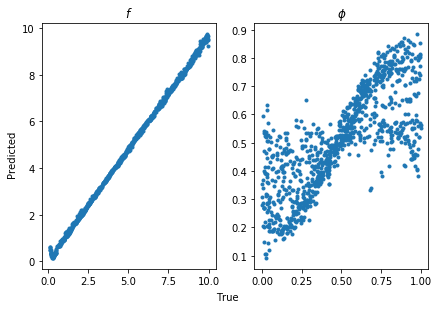

In [20]:
fig, axs = plt.subplots(1,2)
axs = axs.ravel()
for i in range(len(axs)):
    axs[i].plot(y_test[:,i], y_preds[:,i], '.')
plt.tight_layout()
axs[0].set_title(r'$f$')
axs[1].set_title(r'$\phi$')
fig.text(0.5, -0.01, 'True', ha='center')
fig.text(-0.01, 0.5, 'Predicted', va='center', rotation='vertical')
plt.show()

## Exercise 4: Using GAN for Generating Hand-written Digit Images

**GAN (Generative Adversarial Network)** is a framework proposed by Ian Goodfellow, Yoshua Bengio and others in 2014.  

A GAN can be trained to generate images from random noises.  For example, we can train a GAN on MNIST (hand-written digits dataset) to generate digit images that look like hand-written digit images from MNIST, which could be used to train other neural networks.

The code in this notebook is based on the **GAN MNIST example in TensorFlow by Udacity** which uses TensorFlow, whereas this uses Keras on top of TensorFlow for more straightforward construction of networks.  Many of the ideas on training are from **How to Train a GAN? Tips and tricks to make GANs work**.

## MNIST

MNIST is a well known database of handwritten digits.

In [1]:
import numpy as np
import keras
import keras.backend as K
from keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


The below will download MNIST dataset (if not already).

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

Let's examine sample images.  We use 'gray' color map since it has no color information.

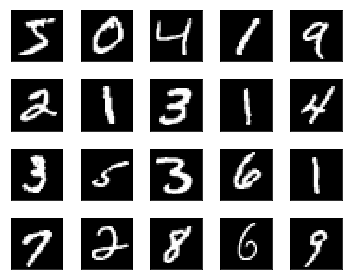

In [3]:
plt.figure(figsize=(5, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

All MNIST digit images come in 28x28 size.

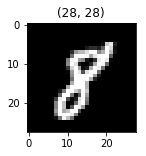

In [4]:
sample = X_train[17]

plt.figure(figsize=(3, 2))
plt.title(sample.shape)
plt.imshow(sample, cmap='gray')
plt.show()

The minimum and maximum sizes of MNIST image data is 0 and 255 respectively.

In [5]:
X_train.min(), X_train.max()

(0, 255)

## Generator

We want to build a generator that generates realistic hand-written images.  

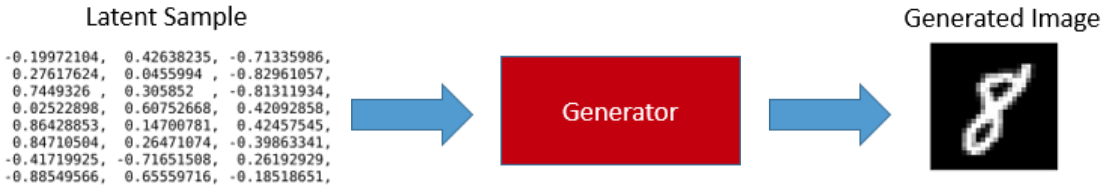

The input to the generator is called 'latent sample' which is a series of randomly generated numbers.  We use the normal distribution rather than the uniform distribution as suggested in.

In [6]:
def make_latent_samples(n_samples, sample_size):
    #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

The sample size is a hyperparameter.  Below, we use a vector of 100 randomly generated number as a sample.

In [7]:
make_latent_samples(1, 100) # generates one sample

array([[-0.7897174 , -0.63770825,  1.0473744 ,  0.8590841 , -0.32766122,
        -0.63535629, -0.17981872,  1.43622493,  0.94429233,  0.58729269,
         0.89013166, -0.86386824, -0.97758644, -0.42363927, -1.18328556,
        -1.56334862, -0.27317438,  0.83923153, -0.92775207, -0.57438735,
         0.76203868, -1.73975797,  0.038801  ,  0.42333229,  0.21311863,
        -0.37398014,  2.59701154, -0.087634  ,  1.00857627, -1.35370238,
        -0.65306192, -2.9331432 , -0.30161398, -0.3995707 ,  0.76448317,
        -0.75093022, -1.30300629, -0.10382331,  0.63355687,  0.71752239,
        -1.36879416,  0.11927632,  0.32820316,  1.27055384,  0.7185253 ,
         0.47303674,  2.64052116, -0.05661673, -0.82330798, -0.78783311,
        -0.65153063,  0.79624579, -0.06994371,  0.07283809, -1.48217313,
         1.0420316 , -2.06357331, -0.51670066,  0.60007148,  0.06664495,
        -1.05284723,  1.23631186, -0.17186641, -1.68174051,  0.15680305,
        -0.1389267 ,  0.21460128,  1.25323858,  0.3

The generator is a simple fully connected neural network with one hidden layer with the leaky ReLU activation.  It takes one latent sample (100 values) and produces 784 (=28x28) data points which represent a digit image.

In [8]:
generator = Sequential()
generator.add(Dense(128, input_shape=(100,)))
generator.add(LeakyReLU(alpha=0.01))
generator.add(Dense(784))
generator.add(Activation('tanh'))
generator.name='generator'

generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               101136    
_________________________________________________________________
activation_1 (Activation)    (None, 784)               0         
Total params: 114,064
Trainable params: 114,064
Non-trainable params: 0
_________________________________________________________________


The last activation is **tanh**.  It means that we need to rescale the MNIST images to be between -1 and 1.

Initially, the generator can only produce garbages.

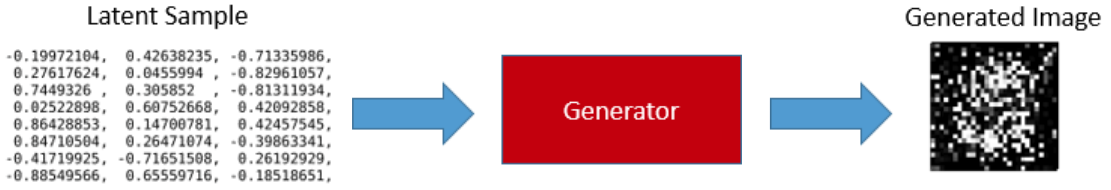

As such, the generator needs to learn how to generate realistic hand-written images from the latent sample (randomly generated numbers).

How to train this generator?  That is the question tackled by GAN.

Before talking about GAN, we shall discuss the discriminator.

## Discriminator

The discriminator takes a digit image and classifies whether an image is real (1) or not (0).  

If the input image is from the MNIST database, the discriminator should classify it as real.

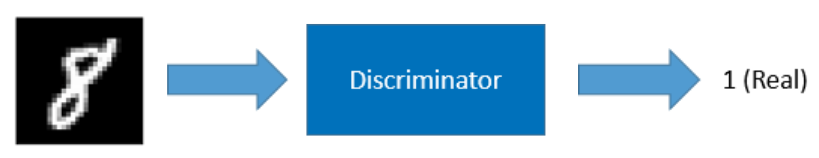

If the input image is from the generator, the discriminator should classify it as fake.

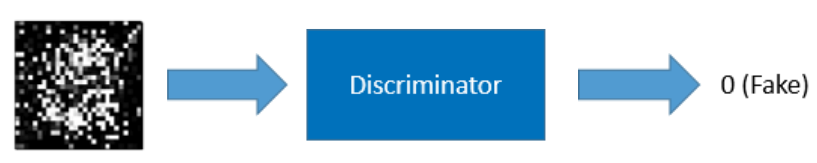

The discriminator is a simple fully connected neural network with one hidden layer with the leaky ReLU activation.

In [10]:
discriminator = Sequential()
discriminator.add(Dense(128, input_shape=(784,)))
discriminator.add(LeakyReLU(alpha=0.01))
discriminator.add(Dense(1))
discriminator.add(Activation('sigmoid'))
discriminator.name='discriminator'

discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


The last activation is **sigmoid** to tell us the probability of whether the input image is real or not.

We train the discriminator using both the MNIST images and the images generated by the generator.

## GAN

We connect the generator and the discriminator to produce a GAN.  

It takes the latent sample, and the generator inside GAN produces a digit image which the discriminator inside GAN classifies as real or fake.

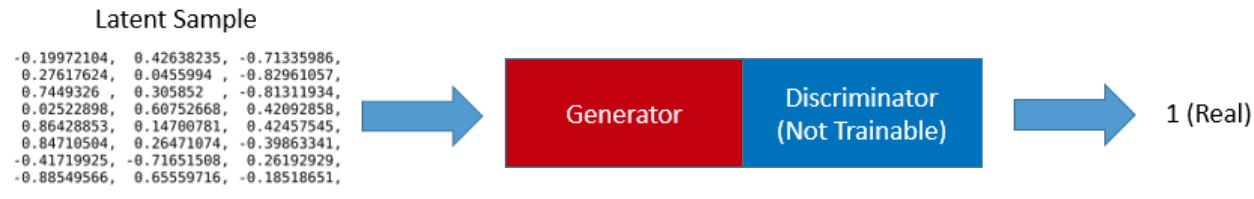

If the generated digit image is so realistic, the discriminator in the GAN classifies it as real, which is what we want to achieve.

We set the discriminator inside the GAN not-trainable, so it is merely evaluating the quality of the generated image.  The label is always 1 (real) so that if the generator fails to produce a realistic digit image, its cost becomes high, and when the back-propagation occurs in GAN, the weights in the generator network gets updated.

In [10]:
# maintain the same shared weights with the generator and the discriminator.
gan = Sequential([
    generator,
    discriminator
])

gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Sequential)       (None, 784)               114064    
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 100609    
Total params: 214,673
Trainable params: 214,673
Non-trainable params: 0
_________________________________________________________________


As you can see, the GAN internally uses the same generator and the discriminator models.  The GAN maintains the same shared weights with the generator and the disriminator.  Therefore, training the GAN also trains the generator.  However, we do not want the discriminator to be affected while training the GAN.

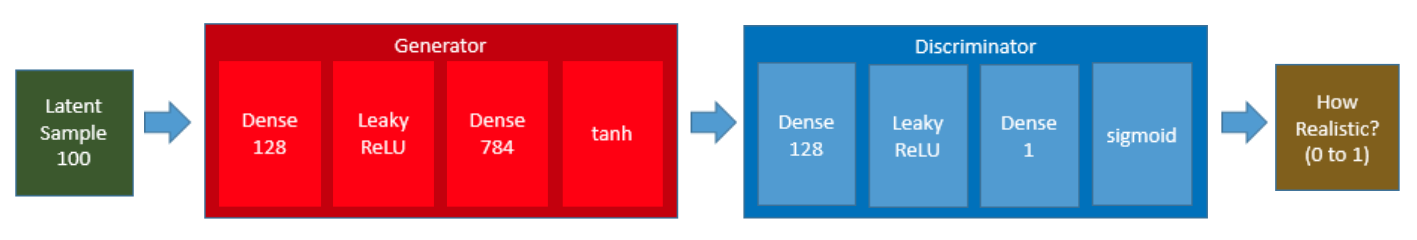

We train the discriminator and the GAN in turn and repeat the training many times until both are trained well.  

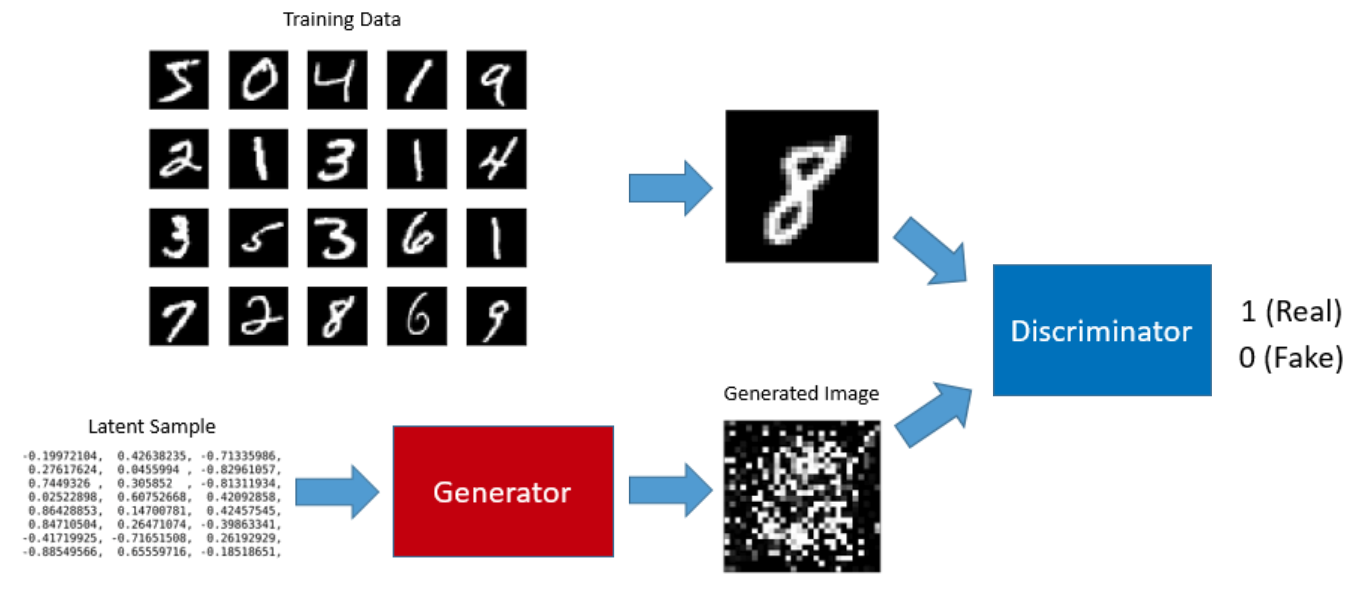

While training the GAN, the back-propagation should update the weights of the generator but not the discriminator.

As such, we need a way to make the discriminator trainable and non-trainable.

In [11]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

In [12]:
make_trainable(discriminator, False)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 100,609
Trainable params: 0
Non-trainable params: 100,609
_________________________________________________________________


In [13]:
make_trainable(discriminator, True)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


The below function combines everything we have discussed so far to build the generator, discriminator, and GAN models and also compile them for training.

In [14]:
def make_simple_GAN(sample_size, 
                    g_hidden_size, 
                    d_hidden_size, 
                    leaky_alpha, 
                    g_learning_rate,
                    d_learning_rate):
    K.clear_session()
    
    generator = Sequential([
        Dense(g_hidden_size, input_shape=(sample_size,)),
        LeakyReLU(alpha=leaky_alpha),
        Dense(784),        
        Activation('tanh')
    ], name='generator')    

    discriminator = Sequential([
        Dense(d_hidden_size, input_shape=(784,)),
        LeakyReLU(alpha=leaky_alpha),
        Dense(1),
        Activation('sigmoid')
    ], name='discriminator')    
    
    gan = Sequential([
        generator,
        discriminator
    ])
    
    discriminator.compile(optimizer=Adam(lr=d_learning_rate), loss='binary_crossentropy')
    gan.compile(optimizer=Adam(lr=g_learning_rate), loss='binary_crossentropy')
    
    return gan, generator, discriminator 

## Training GAN

### Preprocessing

We need to flatten the digit image data as the fully connected input layer expects that.  Also, as the generator uses the **tanh** activation in the output layer, we scale all the MNIST images to have values between -1 and 1.

In [15]:
def preprocess(x):    
    x = x.reshape(-1, 784) # 784=28*28
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

In [16]:
X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

### Deprocessing

We also need a function to reverse the preprocessing so that we can display generated images.

In [17]:
def deprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(28, 28)
    return x

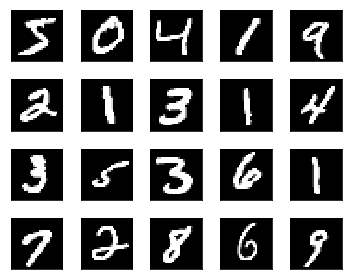

In [18]:
plt.figure(figsize=(5, 4))
for i in range(20):
    img = deprocess(X_train_real[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

### Labels

The labels are 1 (real) or 0 (fake) in 2D shape.

In [19]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

The below is 10 sets of real and fake label values.

In [20]:
y_real_10, y_fake_10 = make_labels(10)

y_real_10, y_fake_10

(array([[ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.]]), array([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]))

Later, we prepare the labels for training and evaluation using the train batch size and the test size.  

### Label Smoothing

One last point before we start training is the label smoothing which makes the discriminator generalize better.

For the real digit images, the labels are all 1s.  However, when we train the discriminator, we use a value slightly smaller than 1 with the real digit images.  Otherwise, the discriminator might overfit to the training data and rejects anything else that is slightly different from the training images.

### Training Loop

We repeat the following to make both the discriminator and the generator better and better:

* Prepare a batch of real images
* Prepare a batch of fake images generated by the generator using latent samples
* Make the discriminator trainable
* Train the discriminator to classify the real and fake images
* Make the discriminator non-trainable
* Train the generator via the GAN

When training the generator via the GAN, the expect labels are all 1s (real).  Initially, the generator produces not very realistic images so the discriminator classifies them as 0s (fake), which causes the back-propagation to adjust the weights inside the generator.  The discriminator is not affected as we set it non-trainable in this step.

In [21]:
# hyperparameters
sample_size     = 100     # latent sample size (i.e., 100 random numbers)
g_hidden_size   = 128
d_hidden_size   = 128
leaky_alpha     = 0.01
g_learning_rate = 0.0001  # learning rate for the generator
d_learning_rate = 0.001   # learning rate for the discriminator
epochs          = 100
batch_size      = 64      # train batch size
eval_size       = 16      # evaluate size
smooth          = 0.1

# labels for the batch size and the test size
y_train_real, y_train_fake = make_labels(batch_size)
y_eval_real,  y_eval_fake  = make_labels(eval_size)

# create a GAN, a generator and a discriminator
gan, generator, discriminator = make_simple_GAN(
    sample_size, 
    g_hidden_size, 
    d_hidden_size, 
    leaky_alpha, 
    g_learning_rate,
    d_learning_rate)

losses = []
for e in range(epochs):
    for i in range(len(X_train_real)//batch_size):
        # real MNIST digit images
        X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]
        
        # latent samples and the generated digit images
        latent_samples = make_latent_samples(batch_size, sample_size)
        X_batch_fake = generator.predict_on_batch(latent_samples)
        
        # train the discriminator to detect real and fake images
        make_trainable(discriminator, True)
        discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
        discriminator.train_on_batch(X_batch_fake, y_train_fake)

        # train the generator via GAN
        make_trainable(discriminator, False)
        gan.train_on_batch(latent_samples, y_train_real)
    
    # evaluate
    X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]
    
    latent_samples = make_latent_samples(eval_size, sample_size)
    X_eval_fake = generator.predict_on_batch(latent_samples)

    d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
    d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
    g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!
    
    losses.append((d_loss, g_loss))
    
    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
        e+1, epochs, d_loss, g_loss))    

Epoch:   1/100 Discriminator Loss: 0.9538 Generator Loss: 5.5816
Epoch:   2/100 Discriminator Loss: 0.1899 Generator Loss: 2.1410
Epoch:   3/100 Discriminator Loss: 0.3655 Generator Loss: 1.4118
Epoch:   4/100 Discriminator Loss: 0.1344 Generator Loss: 3.0701
Epoch:   5/100 Discriminator Loss: 0.3473 Generator Loss: 2.3738
Epoch:   6/100 Discriminator Loss: 0.5153 Generator Loss: 3.7222
Epoch:   7/100 Discriminator Loss: 0.5159 Generator Loss: 3.5699
Epoch:   8/100 Discriminator Loss: 0.7343 Generator Loss: 2.1149
Epoch:   9/100 Discriminator Loss: 0.4661 Generator Loss: 2.3607
Epoch:  10/100 Discriminator Loss: 0.2888 Generator Loss: 2.4522
Epoch:  11/100 Discriminator Loss: 0.4095 Generator Loss: 1.5612
Epoch:  12/100 Discriminator Loss: 0.5406 Generator Loss: 2.7845
Epoch:  13/100 Discriminator Loss: 0.3287 Generator Loss: 2.6246
Epoch:  14/100 Discriminator Loss: 0.2806 Generator Loss: 2.9350
Epoch:  15/100 Discriminator Loss: 0.6982 Generator Loss: 3.5069
Epoch:  16/100 Discrimina

### Stabilizing GAN

As it turns out, training a GAN is quite hard, and there are many tricks and heuristics required.  It is because the discriminator and the generator are not cooperating and individually learning to predict better.  

For example, the generator might learn to fool the discriminator with garbage.   Ideally, the discriminator should learn earlier than the generator so that it can classify images accurately.

Therefore, I used different learning rates for the generator and the discriminator.  I wanted to slow down the generator learning so that the discriminator learns to classify well.

I am not 100% certain if this is a generally good strategy to use but it does seem to work in this project.

As the generator learns more and the loss decreases, the discriminator's loss increases.  I see kind of equilibrium around 80-90 epochs.

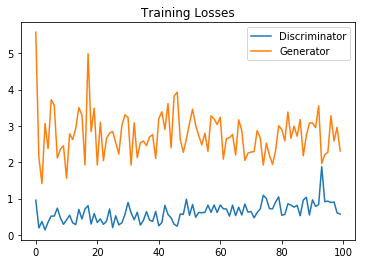

In [22]:
losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

### Tracking Failures

* The discriminator loss = 0 means something is wrong
* When things are working, the discriminator loss has low variance and goes down over time.
* When things are not working, the discriminator loss has huge variance and spiking
* If the generator loss steadily decreases, it is fooling the discriminator with garbage.


### Don't balance via loss statistics 

* i.e., don't try to find a (number of G/number of D) schedule to uncollapse training

## Testing the Generator

Now we generates some digit images using the trained generator.

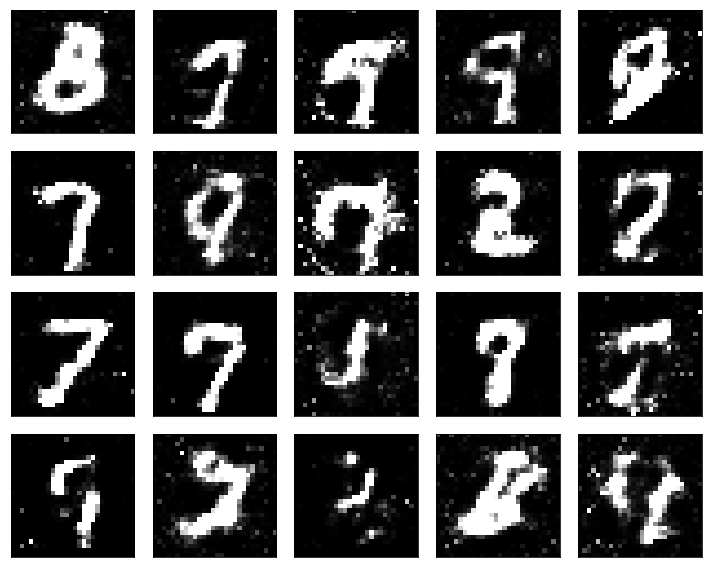

In [23]:
latent_samples = make_latent_samples(20, sample_size)
generated_digits = generator.predict(latent_samples)

plt.figure(figsize=(10, 8))
for i in range(20):
    img = deprocess(generated_digits[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

The results are not outstanding as we are using simple networks.  Deep Convolutional GAN (aka DCGAN) would produce better results than this.